In [1]:
# Adaptation of https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
import dds
import sklearn
import pandas as pd
import logging
logging.basicConfig(level=logging.DEBUG)

import numpy as np
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import requests
import io
import json
import dds


In [3]:
dds.eval(lambda: (
1
+
1))

DEBUG:dds._api:_eval_new_ctx: local_vars: ['GridSearchCV', 'In', 'Out', 'RandomForestRegressor', '_', '_2', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_i3', '_ih', '_ii', '_iii', '_oh', 'dds', 'exit', 'get_ipython', 'io', 'json', 'logging', 'make_pipeline', 'mean_squared_error', 'np', 'pd', 'preprocessing', 'quit', 'r2_score', 'requests', 'sklearn', 'train_test_split']
DEBUG:dds.fun_args:get_arg_ctx: <function <lambda> at 0x7fd70c2d8310>: arg_sig=() args=()
DEBUG:dds._api:arg_ctx: FunctionArgContext(named_args=OrderedDict(), inner_call_key=None)
DEBUG:dds.introspect:_introspect: <function <lambda> at 0x7fd70c2d8310>: fun_path=<__main__.<lambda>> fun_module=<module '__main__'>
DEBUG:dds.introspect:_introspect: is_lambda: <function <lambda> at 0x7fd70c2d8310>
DEBUG:dds.introspect:_introspect: is_lambda: fun_path=<__main__.<lambda>5cb80a73e4bdc09d74a31964f89ab33db239a0d6c5bb934900954e150c8a219f> s

2

In [ ]:
raise

In [2]:
%%sh
rm -rf /tmp/data/*
rm -rf /tmp/blobs/*
rm -rf /tmp/*.png

In [3]:
path_raw = "/wine-quality/raw"
path_model = "/wine-quality/my_model"
path_model_stats = "/wine-quality/my_model_stats.json"

def _load_data():
    print("*** in _load_data ***")
    url = "https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv"
    x = requests.get(url=url, verify=False).content 
    return pd.read_csv(io.StringIO(x.decode('utf8')), sep=";")


def data():
    return dds.keep(path_raw, _load_data)
# data = lambda: dds.keep(path_raw, _load_data)

In [4]:
data().head(3)

INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__._load_data> /wine-quality/raw -- ccd1ea3124
INFO:dds._api:   `- Ctx None
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function _load_data at 0x7fd6061d91f0> with args [] kwargs OrderedDict()
/home/tjhunter/work/software/miniconda/envs/dds/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function _load_data at 0x7fd6061d91f0>: completed
INFO:dds._api:_eval:Storing blob into key ccd1ea31245b11507b79fdf02946f9438d7de3b6933ac87348ed8cb94a7bc0d5
INFO:dds.codec:Loading pandas codecs
INFO:dds.store:Link /tmp/data/wine-quality/raw -> /tmp/blobs/ccd1ea31245b11507b79fdf02946f9438d7de3b6933ac87348ed8cb94a7bc0d5


*** in _load_data ***


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [5]:
def build_model(X_train, y_train):
    print("*** in build_model ***")
    pipeline = make_pipeline(preprocessing.StandardScaler(), 
                             RandomForestRegressor(n_estimators=100))
    hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                      'randomforestregressor__max_depth': [None, 5, 3, 1]}

    clf = GridSearchCV(pipeline, hyperparameters, cv=10)
    
    clf.fit(X_train, y_train)
    return clf
 
    
def model_stats(clf, X_test, y_test) -> str:
    print("*** in model_stats ***")
    pred = clf.predict(X_test)
    return json.dumps({
#         "r2_score": r2_score(y_test, pred),
        "mse": mean_squared_error(y_test, pred)
    })
    
    
def pipeline():
    wine_data = data()
    y = wine_data.quality
    X = wine_data.drop('quality', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.15, 
                                                        random_state=123, 
                                                        stratify=y)
    clf = dds.keep(path_model, build_model, X_train, y_train)
    dds.keep(path_model_stats, model_stats, clf, X_test, y_test)
    print("*** done ***")


# dds.eval(pipeline, dds_export_graph="1.png")


In [6]:
%%sh
# cat /tmp/data/wine-quality/my_model_stats.json

In [23]:

@dds.dds_function("/p1")
def f1(): return 2

@dds.dds_function("/p2")
def f2(): return 2 + f1()

@dds.dds_function("/p3")
def f3(): return 1 + f1() + f2()

@dds.dds_function("/p4")
def f4(): return 1


def f():
    f4()
    f3()

dds.eval(f, dds_export_graph="/tmp/2.png", dds_extra_debug=True)

INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__.f> @ cbe62eade1
INFO:dds._api:   |- Ctx None
INFO:dds._api:   |- Fun <__main__.f4> /p4 <- *f609f1b0e3
INFO:dds._api:   |  `- Ctx 0ba3d60391
INFO:dds._api:   `- Fun <__main__.f3> /p3 <- *5641341715
INFO:dds._api:      |- Ctx 0924e5971c
INFO:dds._api:      |- Fun <__main__.f1> /p1 <- *5288fae92e
INFO:dds._api:      |  `- Ctx 209b35c622
INFO:dds._api:      `- Fun <__main__.f2> /p2 <- *28bf1959ff
INFO:dds._api:         |- Ctx 249adb3e74
INFO:dds._api:         `- Fun <__main__.f1> /p1 <- *5288fae92e
INFO:dds._api:            `- Ctx d01522cc79
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function f at 0x7fd603c581f0> with args [] kwargs OrderedDict()
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function f at 0x7fd603c581f0>: completed


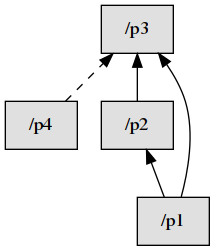

In [24]:
from IPython.display import Image
Image("/tmp/2.png")